# Import Libraries

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
import rasterio
import pandas as pd
import numpy as np

# Load Algeria Shapefile

In [3]:
algeria_shp = gpd.read_file('..\\Shape Files\\gadm41_DZA_shp\\gadm41_DZA_0.shp')
tunisia_shp = gpd.read_file('..\\Shape Files\\gadm41_TUN_shp\\gadm41_TUN_0.shp')

# Load Elevation Raster

In [4]:

elevation = rasterio.open("..\\Elevation dataset\\be15_grd\\be15_grd\\w001000.adf")
print(elevation)
print("CRS:", elevation.crs)

<open DatasetReader name='..\Elevation dataset\be15_grd\be15_grd\w001000.adf' mode='r'>
CRS: EPSG:4326


# Create Combined Boundary

In [5]:
combined_boundary_shp =gpd.GeoDataFrame(
    pd.concat([algeria_shp, tunisia_shp], ignore_index=True),
    crs=algeria_shp.crs
)
def clip_raster(raster_path, boundary):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, boundary.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    with rasterio.open("..\\elevation_algeria_tunisia.tif", "w", **out_meta) as dest:
       dest.write(out_image)

# Clip Raster

In [6]:
clip_raster("..\\Elevation dataset\\be15_grd\\be15_grd\\w001000.adf", combined_boundary_shp)

# Process Elevation Data

 Moyenne : 538.44 m
 Médiane : 464.0 m
 Écart-type : 324.44
Min : -872.0 m
 Max : 2877.0 m


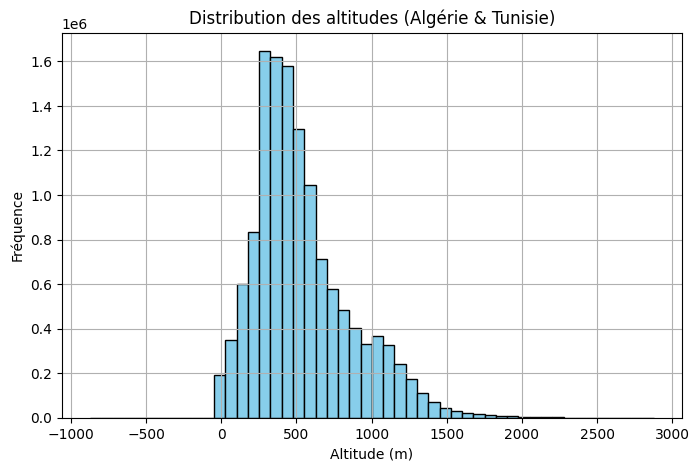

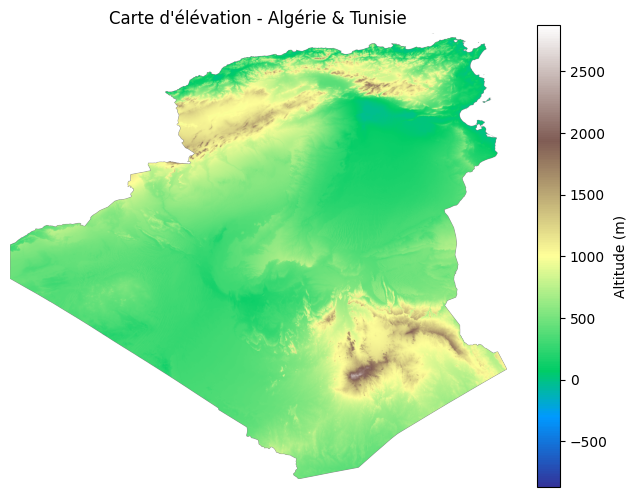

In [8]:

path = "..\\elevation_algeria_tunisia.tif"
src = rasterio.open(path)
data = src.read(1)
nodata = src.nodata
data = np.where(data == nodata, np.nan, data)
valid = data[~np.isnan(data)]
mean = np.mean(valid)
median = np.median(valid)
std = np.std(valid)
min = np.min(valid)
max = np.max(valid)

print(" Moyenne :", round(mean, 2), "m")
print(" Médiane :", round(median, 2), "m")
print(" Écart-type :", round(std, 2))
print("Min :", min, "m")
print(" Max :", max, "m")

plt.figure(figsize=(8,5))
plt.hist(valid, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des altitudes (Algérie & Tunisie)")
plt.xlabel("Altitude (m)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,6))
plt.imshow(data, cmap='terrain')
plt.colorbar(label="Altitude (m)")
plt.title("Carte d'élévation - Algérie & Tunisie")
plt.axis('off')
plt.show()


# Clean Elevation Raster Function

In [ ]:
def clean_elevation_raster(raster_path, output_path=None):
    with rasterio.open(raster_path) as src:
        print(f"  Dimensions: {src.width} x {src.height}")
        elevation = src.read(1)
        profile = src.profile.copy()
        nodata_value = src.nodata
        print(f"\nValeur NoData: {nodata_value}")
        nodata_masks = []
        if nodata_value is not None:
            nodata_masks.append(elevation == nodata_value)
        combined_nodata_mask = np.logical_or.reduce(nodata_masks)
        nodata_count = np.sum(combined_nodata_mask)
        print(f"Pixels NoData détectés: {nodata_count} ({nodata_count/elevation.size*100:.2f}%)")
        elevation = elevation.astype(float)
        elevation[combined_nodata_mask] = np.nan
        valid_elevation = elevation[~np.isnan(elevation)]  
        min_elevation = -33
        max_elevation = 3003
        outlier_mask = (elevation < min_elevation) | (elevation > max_elevation)
        outlier_count = np.sum(outlier_mask)
        print(f"\nValeurs aberrantes (< {min_elevation}m ou > {max_elevation}m): {outlier_count}")
        elevation[outlier_mask] = np.nan
        valid_elevation = elevation[~np.isnan(elevation)]
        print(f"\nStatistiques après nettoyage:")
        print(f"  Pixels valides: {len(valid_elevation)} ({len(valid_elevation)/elevation.size*100:.2f}%)")
        
       
        if output_path:
           
            elevation_save = elevation.copy()
            elevation_save[np.isnan(elevation)] = -9999
            
            profile.update({
                'dtype': 'float32',
                'nodata': -9999
            })
            
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(elevation_save.astype('float32'), 1)
            
            print(f"\nRaster nettoyé sauvegardé: {output_path}")
            return output_path
        
        return raster_path